In [1]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import SGD, Nadam
from keras import layers

import numpy as np
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
# %matplotlib inline
import h5py
from utils import *
import os

Using TensorFlow backend.


In [28]:
DATA_DIR = os.path.abspath('./')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights_new.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base.hdf5')
EXPERIENCE_BUFFER_FILE = os.path.join(DATA_DIR, 'experience_buffer.p')

In [3]:
"""
The neural network consists of a single convolutional block followed by 2 residual blocks followed by final block.
The conv applies the following modules sequentially to its input:
(1) A convolution of 32 filters of kernel size 3×3 with stride 1
(2) Batch normalization
(3) A rectifier nonlinearity
Each residual block applies the following modules sequentially to its input:
(1) A convolution of 32 filters of kernel size 3×3 with stride 1
(2) Batch normalization
(3) A rectifier nonlinearity
(4) A convolution of 32 filters of kernel size 3×3 with stride 1
(5) Batch normalization
(6) A skip connection that adds the input to the block
(7) A rectifier nonlinearity
The final block applies the following modules sequentially to its input:
(1) A convolution of 1 filter of kernel size 1×1 with stride 1
(2) Batch normalization
(3) A rectifier nonlinearity
(4) A fully connected linear layer to a hidden layer of size 32
(5) A rectifier nonlinearity
(6) A fully connected linear layer to a hidden layer of size 4
(7) A rectifier nonlinearity
(8) A concatenation layer which combines the previous layer and input2
(9) A fully connected linear layer to a scalar
"""

'\nThe neural network consists of a single convolutional block followed by 2 residual blocks followed by final block.\nThe conv applies the following modules sequentially to its input:\n(1) A convolution of 32 filters of kernel size 3\xc3\x973 with stride 1\n(2) Batch normalization\n(3) A rectifier nonlinearity\nEach residual block applies the following modules sequentially to its input:\n(1) A convolution of 32 filters of kernel size 3\xc3\x973 with stride 1\n(2) Batch normalization\n(3) A rectifier nonlinearity\n(4) A convolution of 32 filters of kernel size 3\xc3\x973 with stride 1\n(5) Batch normalization\n(6) A skip connection that adds the input to the block\n(7) A rectifier nonlinearity\nThe final block applies the following modules sequentially to its input:\n(1) A convolution of 1 filter of kernel size 1\xc3\x971 with stride 1\n(2) Batch normalization\n(3) A rectifier nonlinearity\n(4) A fully connected linear layer to a hidden layer of size 32\n(5) A rectifier nonlinearity\n(

In [4]:
from keras.regularizers import l2
from keras.initializers import RandomNormal
from keras.layers import Add, Concatenate
from keras.layers.advanced_activations import LeakyReLU

W_init = 'glorot_normal' #'glorot_uniform'
b_init = 'zeros'
W_dense_init = W_init
reg = 1e-3
size = 16


def residual_block(input, reg=1e-6):
    x = conv_block(input)
    x = Conv2D(size, (3,3), padding="same", kernel_regularizer=l2(reg))(x)
    x = BatchNormalization()(x)
    x = Add()([x, input])
    x = Activation('relu')(x)
    return x

def conv_block(input, padding="same", reg=1e-6):
    x = Conv2D(size, (3, 3), padding=padding, kernel_regularizer=l2(reg))(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def final_block(input, input_2, reg=1e-6):
    x = Conv2D(2, (1,1), kernel_regularizer=l2(reg))(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(size, activation = 'relu', kernel_regularizer=l2(reg))(x)
    x = Dense(4, activation = 'relu', kernel_regularizer=l2(reg))(x)
    x = Concatenate()([x, input_2])
    x = Dense(1, activation = 'linear', kernel_regularizer=l2(reg))(x)
    return x

INPUT_SHAPE = (15, 15, 28*2)
input_1 = Input(shape=INPUT_SHAPE, name="input1")
input_2 = Input(shape=(2,), name="input2")
x = conv_block(input_1, reg=reg)
for _ in range(2):
    x = residual_block(x,reg=reg)
x = final_block(x, input_2, reg=reg)
convnet = Model(inputs = [input_1, input_2], outputs = x)
print(convnet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 15, 15, 56)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 16)   8080        input1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 15, 15, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 15, 15, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [5]:
from keras.utils import plot_model
plot_model(convnet, to_file='model.png')

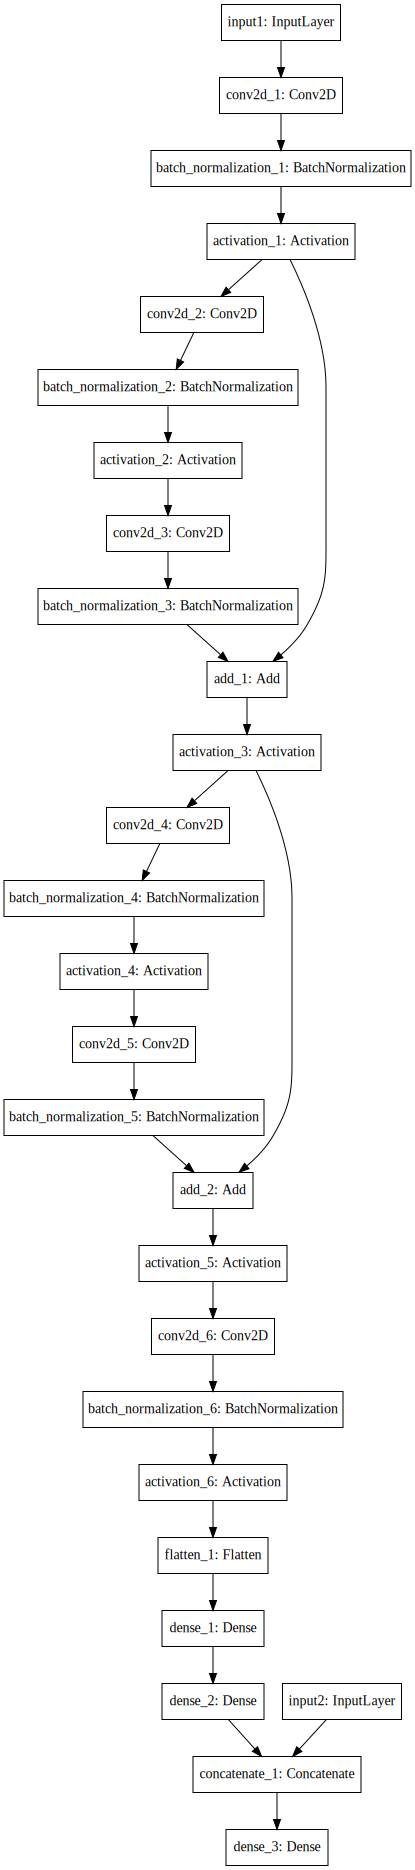

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(convnet).create(prog='dot', format='svg'))

In [7]:
from keras import layers
# from keras.layers import Subtract
base_network = convnet
input_a_1 = Input(shape=INPUT_SHAPE, name='input_11')
input_a_2 = Input(shape=(2,), name='input_12')
processed_a = base_network(inputs = [input_a_1, input_a_2])
input_b_1 = Input(shape=INPUT_SHAPE, name='input_21')
input_b_2 = Input(shape=(2,), name='input_22')
processed_b = base_network(inputs = [input_b_1, input_b_2])
negative_b =  Lambda(lambda x: -x)(processed_b)
distance = layers.Add()([processed_a, negative_b])
out = Activation('sigmoid')(distance)
siamese_net = Model(inputs = [input_a_1, input_a_2, input_b_1, input_b_2], outputs = out)
siamese_net.save_weights(INIT_WEIGHTS)
print(siamese_net.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 15, 15, 56)   0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 15, 15, 56)   0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
model_1 (M

In [11]:
# Load moves
import cPickle as pickle
MOVES = pickle.load(open("../moves_dict.p", "rb"))
# Load Boards
BOARDS = pickle.load(open("../boards_dict.p", "rb"))
keys = BOARDS.keys()

In [11]:
import convert_boards; reload(convert_boards)
from convert_boards import convert_board
board = BOARDS[keys[0]][0]
x = convert_board(board)

In [12]:
for key in BOARDS:
    print(BOARDS[key][0])
    break

[['=' ' ' ' ' "'" ' ' ' ' ' ' '=' ' ' ' ' ' ' "'" ' ' ' ' '=']
 [' ' 'L' ' ' ' ' ' ' 'K' ' ' ' ' ' ' '"' ' ' ' ' ' ' '-' ' ']
 [' ' 'W' 'H' 'I' 'N' 'G' 'Y' ' ' "'" ' ' ' ' ' ' '-' ' ' ' ']
 ['P' 'E' 'E' 'D' ' ' 'O' ' ' "'" ' ' 'J' 'A' 'M' 'A' 'A' 'T']
 [' ' 'I' ' ' ' ' '-' 'T' ' ' ' ' 'N' 'A' 'R' 'I' 'A' 'L' ' ']
 [' ' '"' ' ' ' ' ' ' 'L' ' ' ' ' ' ' 'V' ' ' ' ' ' ' '"' ' ']
 [' ' ' ' "'" ' ' ' ' 'A' "'" ' ' "'" 'E' ' ' ' ' "'" ' ' ' ']
 ['=' ' ' ' ' "'" ' ' 'S' 'C' 'O' 'W' 'L' 's' "'" ' ' ' ' '=']
 [' ' ' ' "'" ' ' ' ' ' ' "'" ' ' "'" ' ' 'P' ' ' 'F' ' ' ' ']
 [' ' '"' ' ' ' ' ' ' '"' ' ' ' ' ' ' '"' 'U' ' ' 'I' '"' ' ']
 [' ' ' ' ' ' ' ' '-' ' ' ' ' ' ' ' ' ' ' 'D' ' ' 'O' ' ' ' ']
 ["'" ' ' ' ' '-' ' ' 'G' 'R' 'O' 'U' 'N' 'D' 'E' 'R' ' ' "'"]
 [' ' ' ' 'F' 'O' 'G' 'I' 'E' ' ' "'" ' ' 'E' ' ' 'D' ' ' ' ']
 [' ' 'R' 'A' 'M' 'I' 'N' ' ' ' ' ' ' '"' 'R' ' ' ' ' '-' ' ']
 ['=' ' ' ' ' 'S' 'E' 'N' 'O' 'p' 'I' 'A' ' ' "'" ' ' ' ' '=']]


In [13]:
num = len(keys) + 1
BOARDS_small = {k: BOARDS[k] for k in keys[:num]}
scores_leaves = {k : [i[:2] for i in v] for k, v in MOVES.iteritems() if k in BOARDS_small}

In [14]:
# import convert_boards; reload(convert_boards)
# from convert_boards import convert_boards
# boards = convert_boards(BOARDS_small)
boards = BOARDS_small

In [15]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=1, verbose = 1, min_lr=5e-8)
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=1e-3,
                              patience=25,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_acc')

In [16]:
import utils_board; reload(utils_board)
from utils_board import DataGeneratorTest, BoardDataGenerator

# keys_small = keys[:100000]
# board_small = {k : boards[k] for k in keys_small}
# scores_small = {k: scores[k] for k in keys_small}

BATCH_SIZE = 32 #512
EXPERIENCE_BUFFER_FILE = "experience_buffer/test_scores.npz" 
load_from_file = False #os.path.exists(EXPERIENCE_BUFFER_FILE)
save_to_file = True
datagen = BoardDataGenerator(boards, scores_leaves, batch_sz = BATCH_SIZE, load_from_file = load_from_file, 
                 save_to_file = save_to_file)

Experience buffer generated
Experience buffer saved to experience_buffer.p
Train: 568313 Val: 11599


In [17]:
# NUM_TRAIN = 187494
# NUM_VAL = 3750
NUM_TRAIN, NUM_VAL = datagen.get_num_pairs()
STEPS_PER_EPOCH = NUM_TRAIN//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL//BATCH_SIZE

In [29]:
nadam = Nadam(lr=1e-6)
siamese_net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
# siamese_net.load_weights(INIT_WEIGHTS)

In [30]:
siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
history = siamese_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=10,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/10
  388/17759 [..............................] - ETA: 13:21 - loss: 0.0103 - acc: 1.0000

KeyboardInterrupt: 

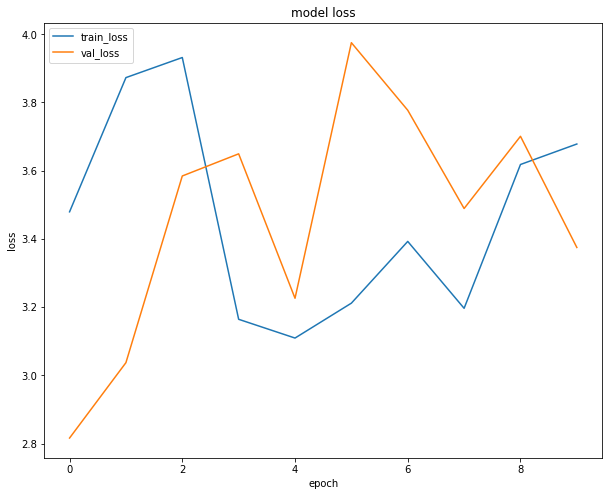

In [31]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.savefig('results_scores_NN_raw1.png')

In [ ]:
# # for i in range(2):
#     if i == 0:
#         print("Base weights:")
#         siamese_net.set_weights(BASE_WEIGHTS)
#     else:
#         print("Checkpointed weights:")
#         siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
#     val = siamese_net.evaluate_generator(
#             datagen.next_train(),
#             steps=STEPS_PER_EPOCH)
#     print("Loss: {} Acc: {}".format(val[0], val[1]))

In [ ]:
# siamese_net.set_weights(BASE_WEIGHTS)
siamese_net.load_weights(CHECKPOINTED_WEIGHTS)
SAVE_MODEL = "keras_tensorflow"
model_to_save = siamese_net.layers[4]
model_to_save.summary()
model_to_save.save(SAVE_MODEL, overwrite='True')

In [ ]:
# model_to_save.get_weights()


In [ ]:
status = os.system("python keras_to_tensorflow.py keras_tensorflow")
if status == 0:
    print("Success")